In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [2]:
FUND = "1982-1988"
RANGE = "YTD"

In [3]:
financial_data = pd.read_csv("combined_results.csv")
financial_data["report_date"] = pd.to_datetime(financial_data["report_date"])
financial_data.head()

,Unnamed: 0,company_name,fund_code,fund_name,number_of_participants,unit_value_change_ytd_pct,bik_pct,predicted_bik_pct,report_date,fund_type,company_short,relative_change
0,944,Allianz Lietuva gyvybės draudimas UAB,AVI-03/09,Allianz D1 2003-2009 tikslinės grupės pensijų ...,1284,-8.190000,NaN,NaN,2025-03-31,2003-2009,Allianz,-8.190000
1,84,Allianz Lietuva gyvybės draudimas UAB,AVI-03/09,Allianz D1 2003-2009 tikslinės grupės pensijų ...,1320,-3.930000,NaN,NaN,2025-06-30,2003-2009,Allianz,4.640019
2,226,Allianz Lietuva gyvybės draudimas UAB,AVI-03/09,Allianz D1 2003-2009 tikslinės grupės pensijų ...,2417,4.690000,NaN,NaN,2025-09-30,2003-2009,Allianz,8.972633
3,328,Allianz Lietuva gyvybės draudimas UAB,AVI-03/09,Allianz D1 2003-2009 tikslinės grupės pensijų ...,2449,9.980000,NaN,NaN,2025-12-31,2003-2009,Allianz,5.053008
4,750,UAGDPB „Aviva Lietuva“,AVI-54/60,Aviva B 1954–1960 tikslinės grupės pensijų fondas,20039,-4.863393,1.0,1.0,2020-03-31,1954-1960,Allianz,-4.863393


### Helpers

In [4]:
def get_period_options(df: pd.DataFrame) -> list[str]:
    dates = pd.to_datetime(df["report_date"])

    min_date = dates.min()
    max_date = dates.max()

    year_span = max_date.year - min_date.year
    options = ["YTD", "ALL"]
    if year_span >= 1:
        options = ["YTD"] + [str(y) for y in range(1, year_span + 1)] + ["ALL"]
    return options

In [5]:
def get_ytd_range(df: pd.DataFrame) -> tuple:
    end = df["report_date"].max()
    start = datetime.datetime(end.year, 1, 1)
    return start, end


def get_previous_year_range(df: pd.DataFrame, months: int) -> tuple:
    end = df["report_date"].max()
    base = end - relativedelta(months=months - 1)
    candidates = df.loc[df["report_date"] > base, "report_date"]
    start = candidates.min()
    return start, end


def get_range(df: pd.DataFrame, range) -> tuple:
    if isinstance(range, str) and range.isdigit():
        range = int(range)

    if range == "YTD":
        start, end = get_ytd_range(df)
        return start, end

    if range == "ALL":
        start, end = df["report_date"].min(), df["report_date"].max()
        return start, end

    if isinstance(range, int):
        start, end = get_previous_year_range(df, range * 12)
        return start, end

    raise ValueError("Range must be 'YTD', 'ALL', or an integer")


def get_data_for_range(df: pd.DataFrame, range) -> pd.DataFrame:
    start, end = get_range(df, range)
    mask = (df["report_date"] >= start) & (df["report_date"] <= end)
    return df[mask]

### Cumulative Growth

In [6]:
def geometric_cumulative_growth(series: pd.Series) -> float:
    results = series / 100.0
    if results.empty:
        return float("nan")
    return round(((1.0 + results).prod() - 1.0) * 100.0, 2)


def estimate_growth(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["company_short", "report_date"])
    company_returns = (
        df.groupby("company_short")["relative_change"]
        .apply(geometric_cumulative_growth)
        .reset_index(name="cumulative_growth")
        .sort_values("cumulative_growth", ascending=False)
        .reset_index(drop=True)
    )
    return company_returns

In [7]:
range_data = get_data_for_range(financial_data, RANGE)
range_fund_data = range_data[range_data["fund_type"] == FUND]

growth_table = estimate_growth(range_fund_data)
growth_table

,company_short,cumulative_growth
0,Allianz,10.19
1,Goindex,8.40
2,Artea,8.13
3,Luminor,7.44
4,SEB,6.61
5,Swedbank,4.68


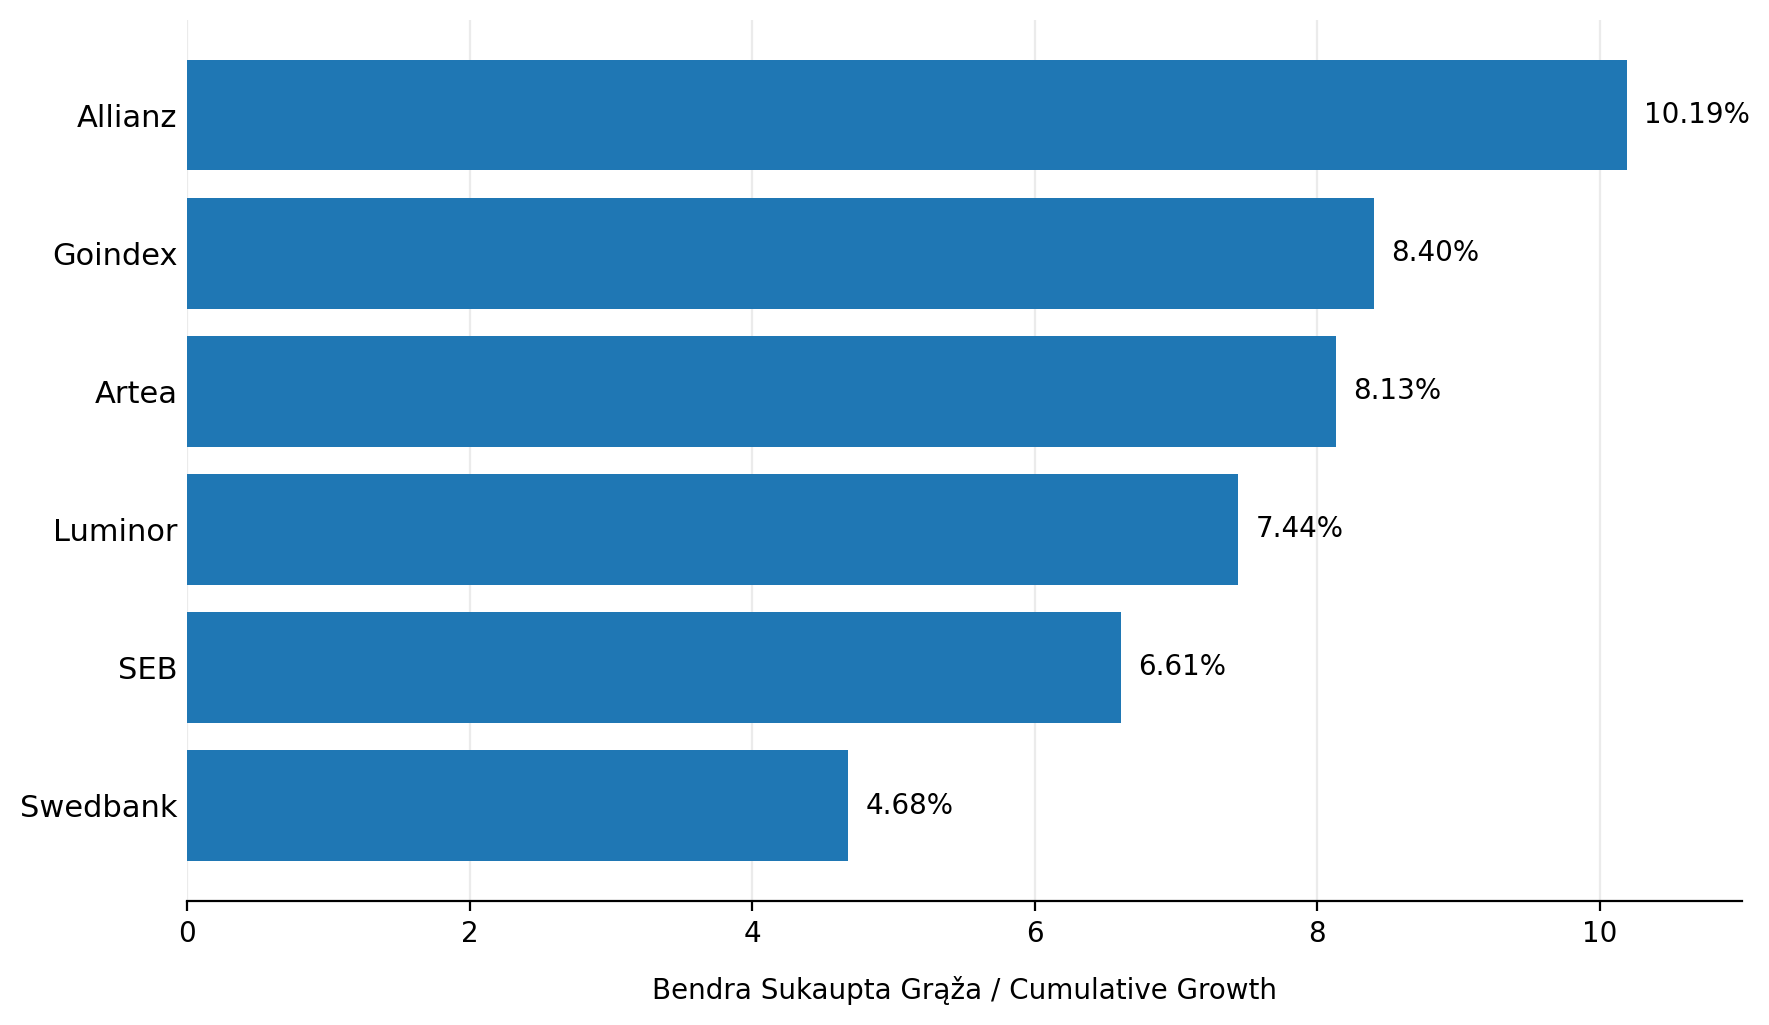

In [8]:
# --- prep ---
df = growth_table.sort_values("cumulative_growth", ascending=True).copy()
xmax = df["cumulative_growth"].max()
pad = xmax * 0.08  # slightly more room for labels

# --- plot ---
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=200)

bars = ax.barh(df["company_short"], df["cumulative_growth"])

# value labels with %
for b, v in zip(bars, df["cumulative_growth"]):
    ax.text(
        b.get_width() + pad * 0.15,
        b.get_y() + b.get_height() / 2,
        f"{v:.2f}%",
        va="center",
        ha="left",
        fontsize=10,
    )

# axes + titles
ax.set_xlim(0, xmax + pad)
ax.set_xlabel("Bendra Sukaupta Grąža / Cumulative Growth", labelpad=10)
ax.set_ylabel("")

# grid
ax.grid(axis="x", linestyle="-", linewidth=0.8, alpha=0.25)
ax.set_axisbelow(True)

# clean spines
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="y", length=0, labelsize=11)
ax.tick_params(axis="x", labelsize=10)

# extra top margin (important for LinkedIn)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# export
plt.savefig("graphs/cumulative_growth_linkedin.png", dpi=200, bbox_inches="tight")
plt.show()

### Average Yearly Returns

In [9]:
def annualised_yearly_return(series: pd.Series) -> float:
    series = series.dropna()
    quarters = len(series)

    if quarters == 0:
        return float("nan")

    years = quarters / 4.0
    if years <= 0:
        return float("nan")

    total_growth_pct = geometric_cumulative_growth(series)
    total_growth = total_growth_pct / 100.0

    annualised = (1.0 + total_growth) ** (1.0 / years) - 1.0
    return round(annualised * 100.0, 2)

In [10]:
def estimate_avg_yearly_return(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["company_short", "report_date"])

    company_returns = (
        df.groupby("company_short")["relative_change"]
        .apply(annualised_yearly_return)
        .reset_index(name="avg_yearly_return")
        .sort_values("avg_yearly_return", ascending=False)
        .reset_index(drop=True)
    )
    return company_returns


avg_yearly_table = estimate_avg_yearly_return(range_fund_data)
avg_yearly_table

,company_short,avg_yearly_return
0,Allianz,10.19
1,Goindex,8.40
2,Artea,8.13
3,Luminor,7.44
4,SEB,6.61
5,Swedbank,4.68


### Worst vs Best Quarter

In [11]:
def company_quarter_extremes(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby("company_short")["relative_change"]

    companies = list(grouped.groups.keys())

    worst = grouped.min().round(2)
    best = grouped.max().round(2)

    result = pd.DataFrame(
        {
            "company_short": companies,
            "worst_quarter": worst,
            "best_quarter": best,
        }
    )

    return result.sort_values("worst_quarter", ascending=True).reset_index(drop=True)


extremes = company_quarter_extremes(range_fund_data)
extremes

,company_short,worst_quarter,best_quarter
0,Allianz,-6.26,8.22
1,Luminor,-6.01,6.98
2,Swedbank,-6.00,4.45
3,SEB,-5.99,6.22
4,Goindex,-5.75,7.26
5,Artea,-4.32,5.43


### Number of Participants

In [12]:
def get_participant_counts(grp: pd.DataFrame) -> dict:
    grp = grp.sort_values("report_date")
    first_val = grp["number_of_participants"].iloc[0]
    last_val = grp["number_of_participants"].iloc[-1]

    return {
        "participants_latest": last_val,
        "participants_change": last_val - first_val,
    }


def participants_table(df: pd.DataFrame, period) -> pd.DataFrame:
    start, end = get_range(df, period)
    df = df[(df["report_date"] >= start) & (df["report_date"] <= end)]

    rows = []
    for company, grp in df.groupby("company_short"):
        info = get_participant_counts(grp)
        rows.append({"company_short": company, **info})

    return (
        pd.DataFrame(rows)
        .sort_values("participants_latest", ascending=False)
        .reset_index(drop=True)
    )


participants = participants_table(range_fund_data, RANGE)
participants

,company_short,participants_latest,participants_change
0,Swedbank,114002,16
1,SEB,74338,249
2,Allianz,48030,22
3,Artea,42682,-55
4,Luminor,28878,958
5,Goindex,10505,2871


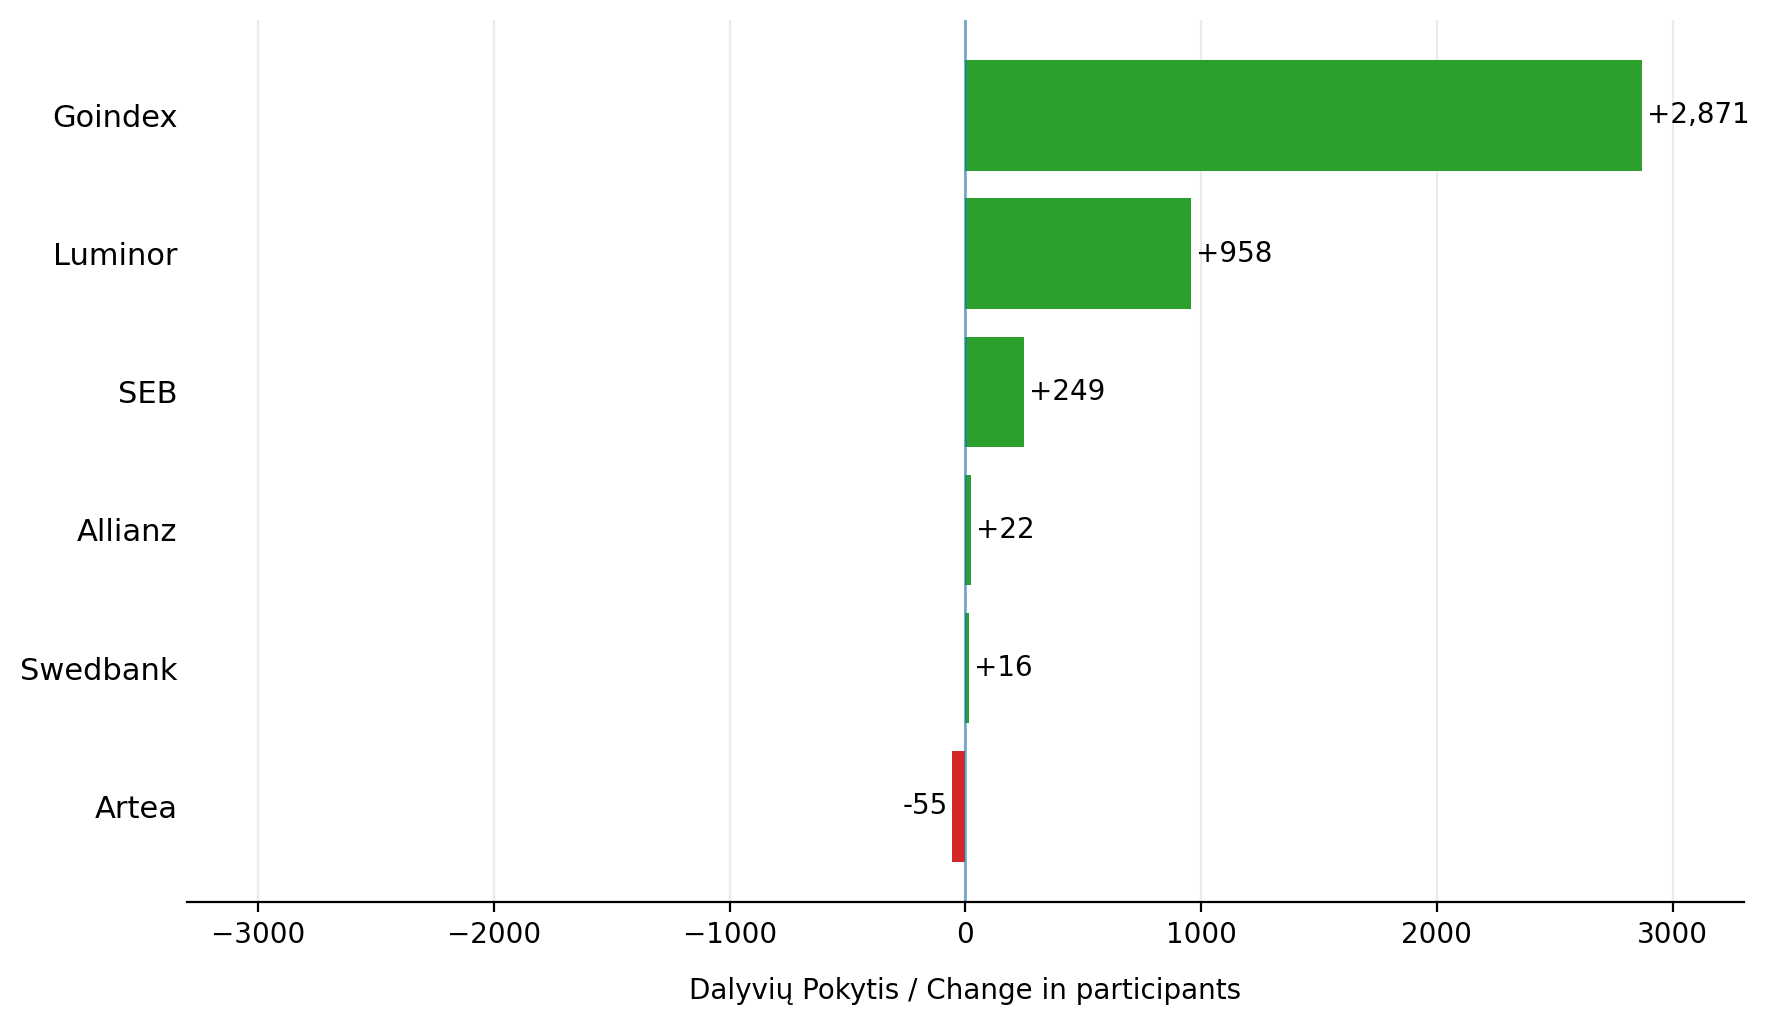

In [13]:
# --- prep ---
df = participants.sort_values("participants_change").copy()

changes = df["participants_change"]
companies = df["company_short"]

max_abs = np.max(np.abs(changes))
pad = max_abs * 0.15

colors = ["#d62728" if v < 0 else "#2ca02c" for v in changes]

# --- plot ---
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=200)

bars = ax.barh(companies, changes, color=colors)

# center line
ax.axvline(0, linewidth=1, alpha=0.6)

# value labels
for b, v in zip(bars, changes):
    ax.text(
        v + (pad * 0.05 if v >= 0 else -pad * 0.05),
        b.get_y() + b.get_height() / 2,
        f"{v:+,}",
        va="center",
        ha="left" if v >= 0 else "right",
        fontsize=10,
    )

# limits & labels
ax.set_xlim(-max_abs - pad, max_abs + pad)
ax.set_xlabel("Dalyvių Pokytis / Change in participants", labelpad=10)
ax.set_ylabel("")

# grid (x only)
ax.grid(axis="x", linewidth=0.8, alpha=0.25)
ax.set_axisbelow(True)

# clean look
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="y", length=0, labelsize=11)
ax.tick_params(axis="x", labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# export
plt.savefig("graphs/participants_change_linkedin.png", dpi=200, bbox_inches="tight")
plt.show()

### Bendrasis Išlaidu Koeficientas (BIK)

In [14]:
def get_bar_latest(grp: pd.DataFrame) -> dict:
    grp = grp.sort_values("report_date")
    last_val = round(grp["bik_pct"].iloc[-1], 3)

    return {"expense_ratio": last_val}


def bar_table(df: pd.DataFrame, period) -> pd.DataFrame:
    start, end = get_range(df, period)
    df = df[(df["report_date"] >= start) & (df["report_date"] <= end)]

    rows = []
    for company, grp in df.groupby("company_short"):
        info = get_bar_latest(grp)
        rows.append({"company_short": company, **info})

    return (
        pd.DataFrame(rows)
        .sort_values("expense_ratio", ascending=False)
        .reset_index(drop=True)
    )


bar = bar_table(range_fund_data, RANGE)
bar

,company_short,expense_ratio
0,Artea,1.260
1,Allianz,0.970
2,SEB,0.820
3,Luminor,0.720
4,Swedbank,0.690
5,Goindex,0.577


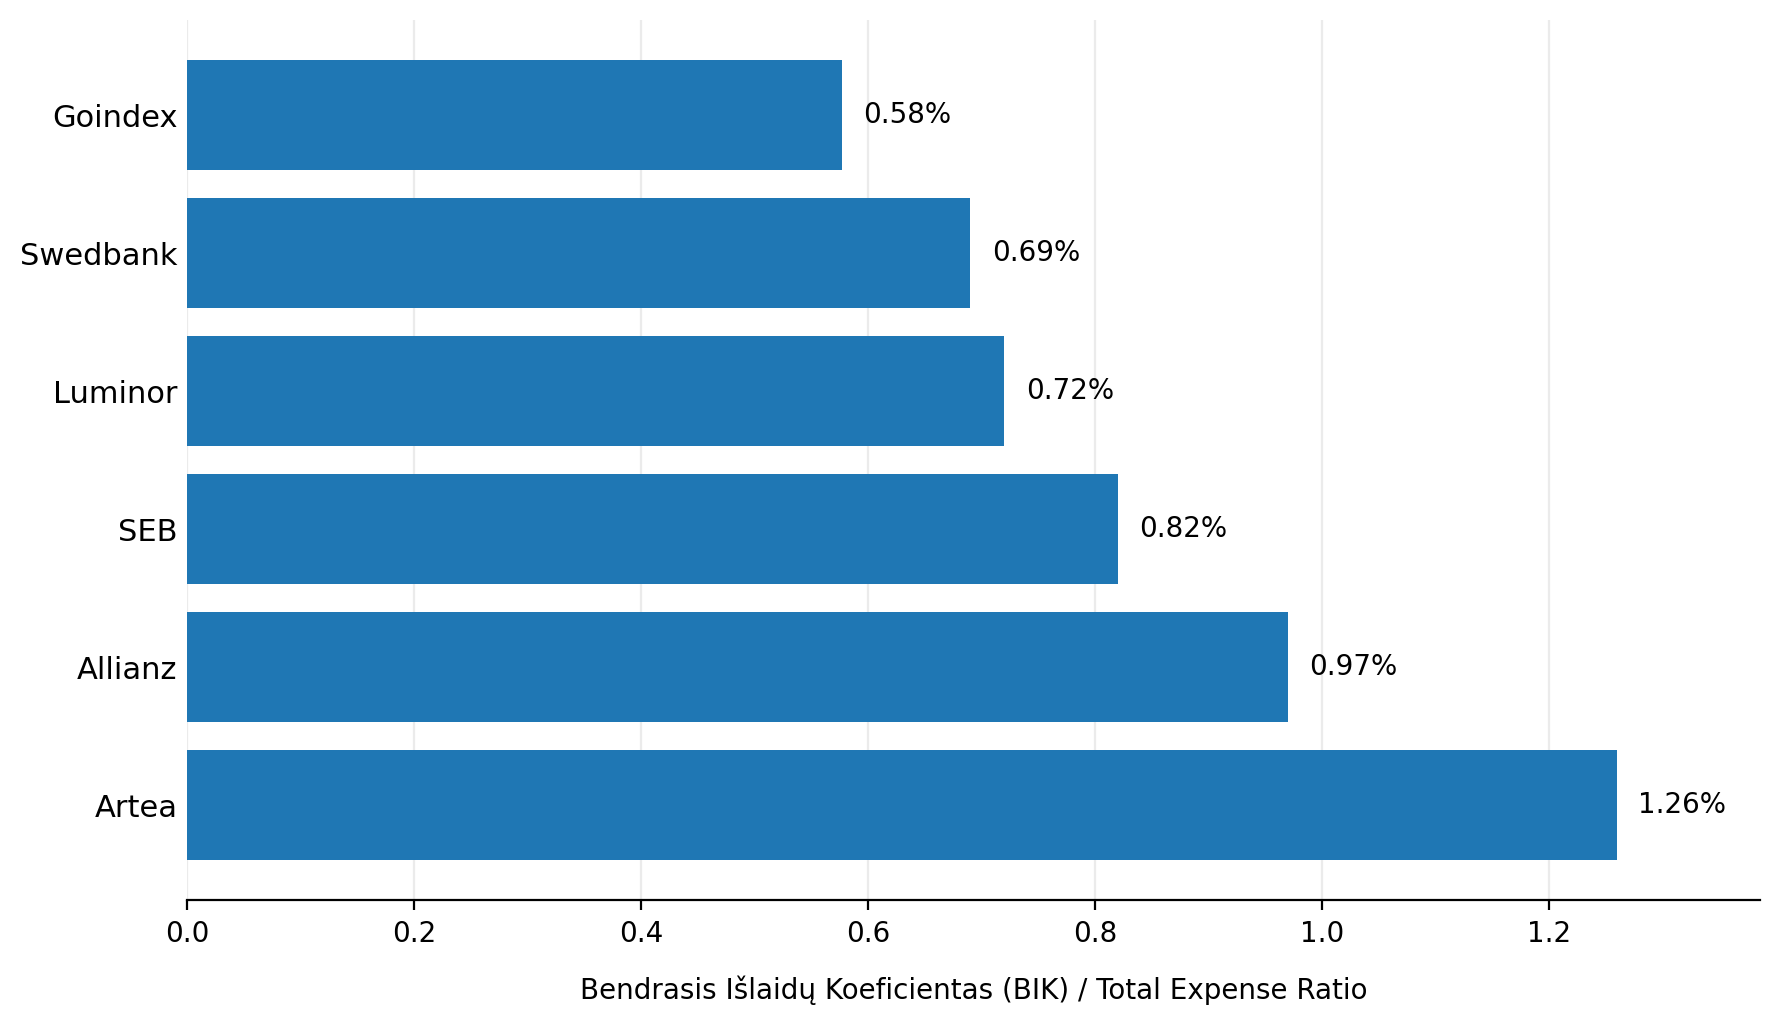

In [15]:
# --- prep ---
df = bar.sort_values("expense_ratio", ascending=False).copy()
xmax = df["expense_ratio"].max()
pad = xmax * 0.10  # space for value labels

# --- plot ---
fig, ax = plt.subplots(figsize=(9, 5.5), dpi=200)

bars = ax.barh(df["company_short"], df["expense_ratio"])

# value labels with %
for b, v in zip(bars, df["expense_ratio"]):
    ax.text(
        b.get_width() + pad * 0.15,
        b.get_y() + b.get_height() / 2,
        f"{v:.2f}%",
        va="center",
        ha="left",
        fontsize=10,
    )

# axes + titles
ax.set_xlim(0, xmax + pad)
ax.set_xlabel("Bendrasis Išlaidų Koeficientas (BIK) / Total Expense Ratio", labelpad=10)
ax.set_ylabel("")

# grid (x only)
ax.grid(axis="x", linewidth=0.8, alpha=0.25)
ax.set_axisbelow(True)

# clean look
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="y", length=0, labelsize=11)
ax.tick_params(axis="x", labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# export
plt.savefig("graphs/expense_ratio_linkedin.png", dpi=200, bbox_inches="tight")
plt.show()